#Note: 



*   Run the notebook in Google Colab
*   Refrer to the Table of Contents to quickly jump through sections.
*   Datasets are being imported from Google Drive directly into the notebook.
*   Final CSV file is being exported at the end of the notebook.

# Imports and Display Settings

In [91]:
import pandas as pd
import string
import regex as re
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

# Set Seaborn theme
sns.set_theme(context='talk', style='whitegrid', palette='summer', font_scale=0.75, color_codes=True, rc=None)

# Set iPython's max row display
pd.set_option('display.max_row', 1000)

# Set iPython's max column width to 50
pd.set_option('display.max_columns', 50)

# Downloading and Extracting Dataset

In [92]:
!gdown --id 1Ng2UEHMiJPP9VqT_5SmXTpYvvcn9dd4m

Downloading...
From: https://drive.google.com/uc?id=1Ng2UEHMiJPP9VqT_5SmXTpYvvcn9dd4m
To: /content/Data-20210310T130153Z-001.zip
235MB [00:02, 105MB/s] 


In [93]:
!unzip '/content/Data-20210310T130153Z-001.zip'

Archive:  /content/Data-20210310T130153Z-001.zip
replace Data/LSOA_pop_v2.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: Data/LSOA_pop_v2.csv    
  inflating: Data/posttrans.csv      
  inflating: Data/postcodes.gz       
  inflating: Data/all_crimes_18_hdr.csv  


In [94]:
!gunzip '/content/Data/postcodes.gz'

gzip: /content/Data/postcodes already exists; do you wish to overwrite (y or n)? y


# Data Cleaning and Preprocessing

## Cleaning Dataset1 - The Crimes Data: Primary Dataset (all_crimes18_hdr.csv)

Reading dataset into dataframe

In [95]:
df_crime = pd.read_csv('/content/Data/all_crimes_18_hdr.csv')

Dropping unnecessary features

In [96]:
df_crime = df_crime.drop(df_crime.columns[[0,1,3,-1,-2]], axis=1)

Renaming columns appropriately

In [97]:
df_crime.rename(columns = {'_c1':'Month', '_c3':'FallsWithin', '_c4':'Longitude', '_c5':'Latitude',
                           '_c6':'Location', '_c7':'LsoaCode', '_c8':'LsoaName', '_c9':'Crime',}, inplace = True)

Removing rows without LSOA information

In [98]:
df_crime = df_crime[df_crime['LsoaCode'].notna()]

Removing 'On or near' substring from location strings

In [99]:
df_crime = df_crime.replace(to_replace ='[Oo]n [oO]r [nN]ear ', value = '', regex = True)

Coverting dataframe to appropriate datatypes

In [100]:
df_crime = df_crime.astype({
    "Month": str, "FallsWithin": str, 'Longitude': float, 'Latitude':float, 'Location': str,
    'LsoaCode': str, 'LsoaName': str, 'Crime': str,})

df_crime: Cleaned Dataframe from Dataset1 (all_crimes18_hdr.csv)

In [101]:
df_crime.sample(5)

,Month,FallsWithin,Longitude,Latitude,Location,LsoaCode,LsoaName,Crime
3054704,2015-07,West Midlands Police,-1.471840,52.437358,Roseberry Avenue,E01009607,Coventry 004C,Anti-social behaviour
426334,2018-03,Sussex Police,-0.460277,50.922312,Steyning Crescent,E01031627,Horsham 012C,Anti-social behaviour
3443881,2015-01,Bedfordshire Police,-0.261424,52.086462,Back Street,E01017385,Central Bedfordshire 005C,Violence and sexual offences
1635333,2016-12,Hertfordshire Constabulary,-0.202379,51.902935,Shopping Area,E01023758,Stevenage 008D,Violence and sexual offences
1519264,2017-02,South Yorkshire Police,-1.353814,53.433115,Shopping Area,E01007714,Rotherham 017B,Anti-social behaviour


## Cleaning Dataset2 - Postcodes Data (postcodes.csv) 

Reading dataset into dataframe and assigning column names

In [102]:
columns = ["Postcode","InUse","Latitude","Longitude","Easting","Northing",
           "GridRef","County","District","Ward","DistrictCode","WardCode",
           "Country","CountyCode","Constituency","Introduced","Terminated",
           "Parish","NationalPark","Population","Households","BuiltUpArea",
           "Builtupsubdivision","LsoaName","Rural_Urban","Region","Altitude"]
df_postcodes = pd.read_csv("/content/Data/postcodes", names=columns, header=None)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7,8,9,11,13,14,15,16,17,18,21,22,23,24,25) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Extracting necessary columns

In [103]:
df_postcodes = df_postcodes[['Postcode','InUse','Latitude','Longitude','District','LsoaName']]

Coverting dataframe to appropriate datatypes

In [104]:
df_postcodes = df_postcodes.astype({
    "Postcode": str, "InUse": str, 'Latitude': float, 'Longitude':float, 'District': str, 'LsoaName': str,})

Removing Terminated Postcodes

In [105]:
df_postcodes = df_postcodes[df_postcodes['InUse'] == 'Yes']

df_postcodes: Cleaned Dataframe from Dataset2 (postcodes.csv)

In [106]:
df_postcodes.sample(5)

,Postcode,InUse,Latitude,Longitude,District,LsoaName
2222238,SY20 9PA,Yes,52.656606,-3.703466,Powys,Powys 004A
1184980,LE1 3EJ,Yes,52.643123,-1.136511,Leicester,Leicester 008B
1381726,MK2 2EE,Yes,51.995973,-0.725524,Milton Keynes,Milton Keynes 030B
856894,G51 4DL,Yes,55.854512,-4.332342,Glasgow City,Drumoyne and Shieldhall - 03
902907,GL56 0LR,Yes,51.987405,-1.699088,Cotswold,Cotswold 002E


## 1st Merge to gain District level information from LSOA

Merging df_crime with df_postcodes on 'LSOA' <br>
Note: (pd.Merge could not be used due to memory limitations)

In [107]:
district_mappings = dict(zip(df_postcodes.LsoaName, df_postcodes.District))
lsoa_list = df_crime['LsoaName']
district = []
for lsoa in lsoa_list:
  try:
    val = district_mappings[lsoa]
    district.append(val)
  except:
    district.append(np.NaN)

In [108]:
df_crime['District'] = district

Updated df_crime with district level information

In [109]:
df_crime.sample(5)

,Month,FallsWithin,Longitude,Latitude,Location,LsoaCode,LsoaName,Crime,District
3182504,2015-05,Metropolitan Police Service,-0.087597,51.388785,Willow Wood Crescent,E01001109,Croydon 013B,Anti-social behaviour,Croydon
423950,2018-03,Surrey Police,-0.419013,51.387655,Parking Area,E01030359,Elmbridge 007C,Anti-social behaviour,Elmbridge
2735852,2015-10,Cleveland Police,-1.054011,54.535084,Parking Area,E01012117,Redcar and Cleveland 018A,Anti-social behaviour,Redcar and Cleveland
3057969,2015-07,West Yorkshire Police,-1.611850,53.691559,Petrol Station,E01011123,Kirklees 018C,Anti-social behaviour,Kirklees
2092491,2016-07,South Wales Police,-3.177560,51.477741,St Mary Street,W01001941,Cardiff 032G,Violence and sexual offences,Cardiff


## Cleaning Dataset4 - Location wise population Data (posttrans.csv) 



Reading dataset into dataframe and assigning column names

In [110]:
columns = ["Date","Lsoa","LsoaCode","Rural_Urban","TotalPopulation","Males",
           "Females","Household","Communal","Child_Student","Area_Hectares","Density"]
df_population = pd.read_csv('/content/Data/LSOA_pop_v2.csv', names=columns,  skiprows = 1)

df_population: Cleaned Dataframe from Dataset4 (posttrans.csv)

In [111]:
df_population.sample(5)

,Date,Lsoa,LsoaCode,Rural_Urban,TotalPopulation,Males,Females,Household,Communal,Child_Student,Area_Hectares,Density
16493,2011,Cambridge 012F,E01032795,Total,1568,758,810,1479,89,25,46.62,33.6
9069,2011,Leeds 070C,E01011618,Total,1581,742,839,1581,0,8,12.76,123.9
26759,2011,New Forest 007C,E01023045,Total,1580,768,812,1538,42,14,716.75,2.2
23291,2011,Hounslow 004E,E01002631,Total,1628,844,784,1628,0,21,20.73,78.5
10594,2011,Charnwood 006A,E01025740,Total,1499,760,739,1454,45,23,564.49,2.7


## 2nd Merge to gain Population at LSOA level from LSOA <br>
Merging df_crime with df_population on 'LSOA'<br>
Note: (pd.Merge could not be used due to memory limitations)

In [112]:
population_mappings = dict(zip(df_population.Lsoa, df_population.TotalPopulation))
lsoa_list = df_crime['LsoaName']
population = []
for lsoa in lsoa_list:
  try:
    val = population_mappings[lsoa]
    population.append(val)
  except:
    population.append(np.NaN)

In [113]:
df_crime['Population'] = population

Updated df_crime with population information

In [114]:
df_crime.sample(5)

,Month,FallsWithin,Longitude,Latitude,Location,LsoaCode,LsoaName,Crime,District,Population
222219,2018-05,Merseyside Police,-2.876089,53.435485,Baron'S Hey,E01006644,Liverpool 017D,Violence and sexual offences,Liverpool,2040
3155147,2015-05,Devon & Cornwall Police,-3.603080,50.535978,Nightclub,E01020217,Teignbridge 014B,Violence and sexual offences,Teignbridge,1657
714166,2017-11,Metropolitan Police Service,-0.155055,51.462581,Forthbridge Road,E01004589,Wandsworth 009E,Violence and sexual offences,Wandsworth,1700
3212943,2015-05,Thames Valley Police,-1.327300,52.063314,Victoria Place,E01028440,Cherwell 004F,Anti-social behaviour,Cherwell,1634
1910614,2016-09,Northumbria Police,-1.526912,55.116328,Keats Avenue,E01027422,Northumberland 024B,Anti-social behaviour,Northumberland,1845


# EDA

##Exploring Claim 1: "The violent crime is increasing with time."

Extracting year wise crime rate [2015-2018]

In [115]:
violentCrimes2015 = df_crime[(df_crime.Month.str.contains('^2015')) & (df_crime.Crime == 'Violence and sexual offences')]
violentCrimes2016 = df_crime[(df_crime.Month.str.contains('^2016')) & (df_crime.Crime == 'Violence and sexual offences')]
violentCrimes2017 = df_crime[(df_crime.Month.str.contains('^2017')) & (df_crime.Crime == 'Violence and sexual offences')]
violentCrimes2018 = df_crime[(df_crime.Month.str.contains('^2018')) & (df_crime.Crime == 'Violence and sexual offences')]

In [116]:
year = ['2015', '2016', '2017', '2018']
crime_rate = [len(violentCrimes2015), len(violentCrimes2016), len(violentCrimes2017), len(violentCrimes2018)]
violentCrimesPerYear = dict(zip(year, crime_rate))

###Visualization and Result

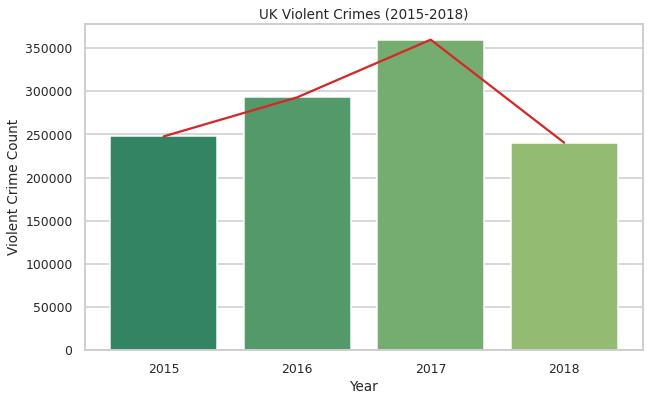

In [117]:
fig, ax1 = plt.subplots(figsize=(10,6))
color = 'tab:green'
ax1.set_title('UK Violent Crimes (2015-2018)')
ax1.set_xlabel('Year')
ax1.set_ylabel('Violent Crime Count')
ax1 = sns.barplot(x=year, y=crime_rate,)
color = 'tab:red'
ax2 = sns.lineplot(x=year, y=crime_rate, sort=False, color=color)
ax2.tick_params(axis='y', color=color)

plt.show()

Refuting Claim 1: In the UK Violent Crime increased consistently from 2015(approx. 250000) to 2017 (approx: 350000). However, in 2018 (approx: 240000), Violent Crime has decreased to its lowest since 2015. 

##Exploring Claim 2: "In Birmingham per head crime rate is higher than anywhere else in UK."

Grouping by District and aggregating on Population and Number of Incidents 

In [118]:
perHeadCrime = df_crime[['LsoaName','District', 'Crime', 'Population']]

In [119]:
perHeadCrime = (df_crime.groupby(['District','LsoaName','Population']).agg({'Crime':'size'})).reset_index()

In [120]:
perHeadCrime = perHeadCrime.groupby(['District']).agg({'Population':'sum', 'Crime':'sum'}).reset_index()

In [121]:
perHeadCrime['CrimePerHead'] = perHeadCrime['Crime']/perHeadCrime['Population']

In [122]:
perHeadCrime = (perHeadCrime.sort_values(by=['CrimePerHead'], ascending=False).reset_index())

In [123]:
del perHeadCrime['index']

###Visualization and Result

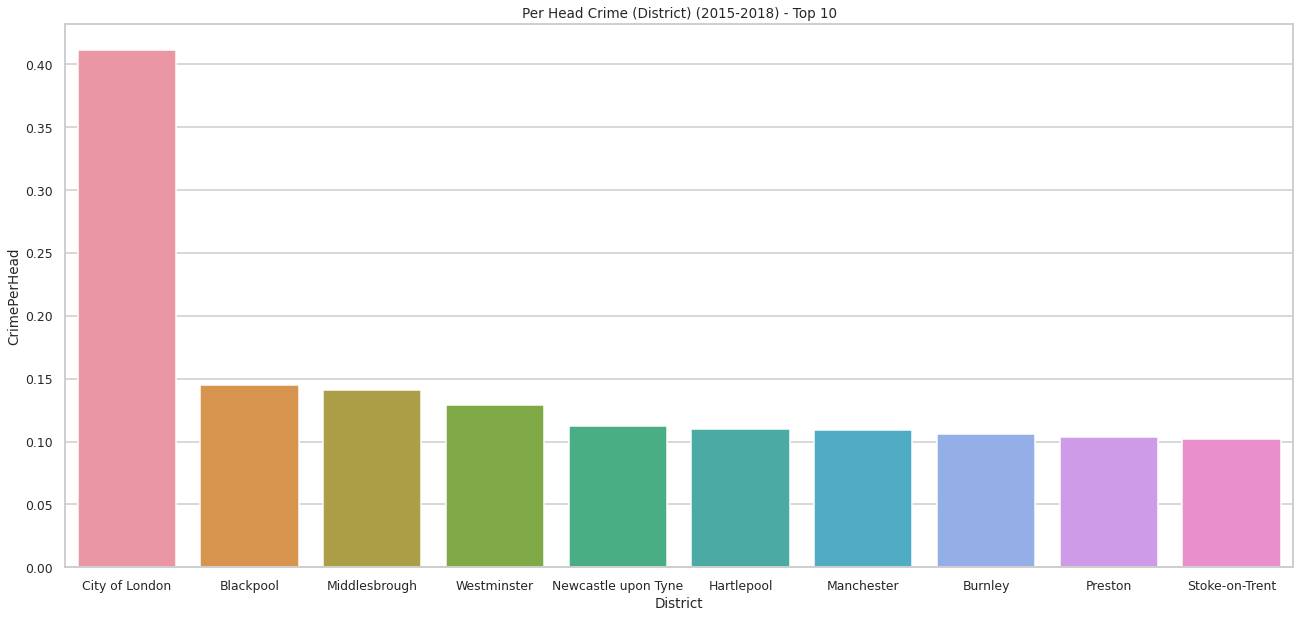

In [124]:
fig, ax1 = plt.subplots(figsize=(22,10))
ax1.set_title('Per Head Crime (District) (2015-2018) - Top 10')
ax1.set_xlabel('District')
ax1.set_ylabel('Crimes per head')
ax1 = sns.barplot(x=perHeadCrime['District'][0:10], y=perHeadCrime['CrimePerHead'][0:10],)

Refuting Claim 2: Birmingham isn't even in the Top 10 Districts with Highest Per Head Crime Rate.

##Exploring Correlation between District and Most Prevalent Crime Type

In [125]:
districtCrime = df_crime[['District', 'Crime']]

In [126]:
districtCrime = (districtCrime.groupby(['District'])[['Crime']].agg(pd.Series.mode)).reset_index()
districtCrime.columns = ['District', 'Most Common Crime']

###Visualization and Result

In [127]:
districtCrime

,District,Most Common Crime
0,Adur,Anti-social behaviour
1,Allerdale,Anti-social behaviour
2,Amber Valley,Anti-social behaviour
3,Arun,Anti-social behaviour
4,Ashfield,Anti-social behaviour
5,Ashford,Violence and sexual offences
6,Aylesbury Vale,Violence and sexual offences
7,Babergh,Violence and sexual offences
8,Barking and Dagenham,Violence and sexual offences
9,Barnet,Anti-social behaviour


##Other interesting insights

## Exploring the change in trend in top 10 districts for drugs related crimes from 2015 to 2018

Extracting all drug crimes in 2015

In [128]:
drug_Crime_2015 = df_crime[(df_crime.Month.str.contains('^2015')) & (df_crime.Crime == 'Drugs')]
drug_Crime_2015 = drug_Crime_2015[['District', 'Crime']]

Grouping for count and selecting top 10 districts with high count of drugs related crimes

In [129]:
drugCrimeDistricts2015 = (drug_Crime_2015.groupby(['District']).agg({'Crime':'count'})).reset_index()
drugCrimeDistricts2015.columns = ['District','Drug Crimes Count 2015']
drugCrimeDistricts2015 = (drugCrimeDistricts2015.sort_values(by=['Drug Crimes Count 2015'], ascending=False).reset_index())

In [130]:
drugCrimeDistricts2015 = drugCrimeDistricts2015.head(10)

Extracting drug crimes for the selected top 10 districts in 2018


In [131]:
drugCrime2018 = df_crime[(df_crime.Month.str.contains('^2018')) & (df_crime.Crime == 'Drugs')& (df_crime.District.isin(drugCrimeDistricts2015.District.values.tolist()))]
drugCrime2018 = drugCrime2018[['District', 'Crime']]

In [132]:
drugCrimeDistrict2018 = (drugCrime2018.groupby(['District']).agg({'Crime':'count'})).reset_index()
drugCrimeDistrict2018.columns = ['District','Drug Crimes Count 2018']
drugCrimeDistrict2018 = (drugCrimeDistrict2018.sort_values(by=['Drug Crimes Count 2018'], ascending=False).reset_index())

Merging content to single dataframe

In [133]:
df_drugMerge2015_2018 = pd.merge(drugCrimeDistricts2015, drugCrimeDistrict2018, left_on='District', right_on='District')
df_drugMerge2015_2018 = df_drugMerge2015_2018[['District','Drug Crimes Count 2015','Drug Crimes Count 2018']]

In [134]:
df_drugMerge2015_2018

,District,Drug Crimes Count 2015,Drug Crimes Count 2018
0,Liverpool,756,533
1,Birmingham,702,322
2,Lambeth,547,269
3,Southwark,515,281
4,Leeds,496,316
5,Westminster,488,232
6,Brent,440,220
7,Manchester,413,249
8,Nottingham,405,264
9,Camden,377,176


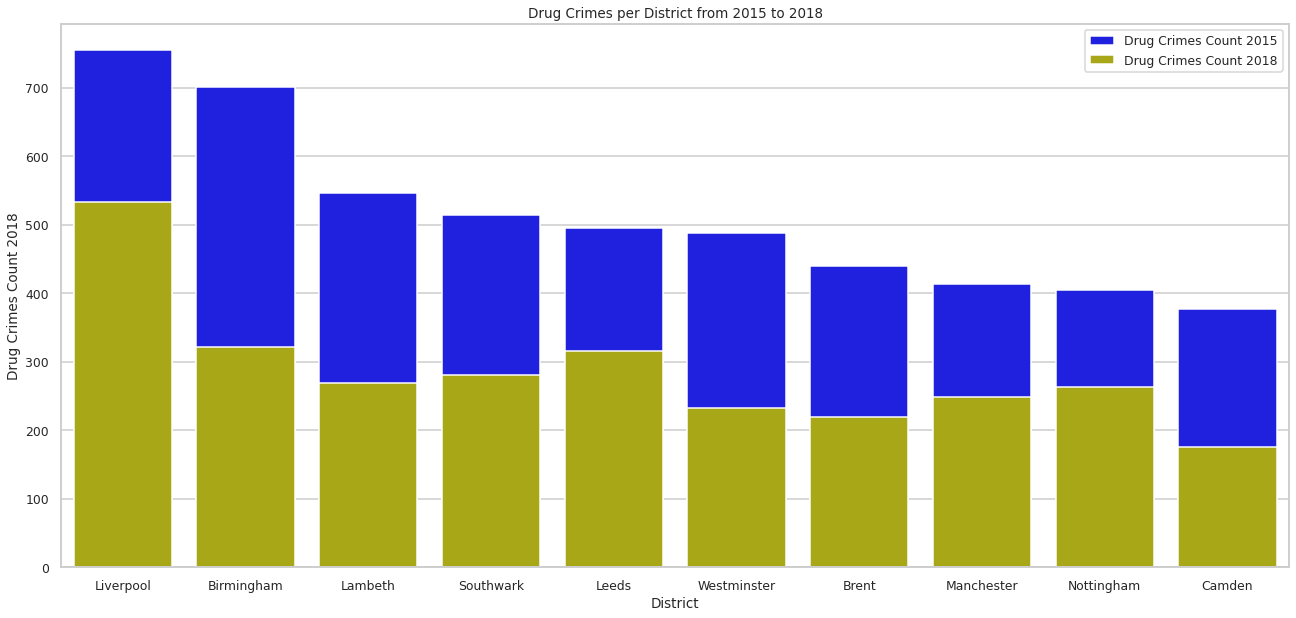

In [135]:
fig, ax1 = plt.subplots(figsize=(22,10))
ax1.set_title('Drug Crimes per District from 2015 to 2018')
ax1.set_xlabel('District')
ax1.set_ylabel('Drug Crimes Count')
ax1 = sns.barplot(x=df_drugMerge2015_2018['District'], y=df_drugMerge2015_2018['Drug Crimes Count 2015'], color='b', label = 'Drug Crimes Count 2015')
ax1 = sns.barplot(x=df_drugMerge2015_2018['District'], y=df_drugMerge2015_2018['Drug Crimes Count 2018'], color='y' , label = 'Drug Crimes Count 2018')
ax1.legend()
plt.show()

The graph shows a significant decrease in number of drug related crimes in 2018 in the top 10 districts for reported crimes in 2015. 

In [136]:
df_density = df_population[['Lsoa','Density']]
df_density

,Lsoa,Density
0,Darlington 001B,0.4
1,Darlington 001C,12.1
2,Darlington 001D,0.3
3,Darlington 001E,9.3
4,Darlington 001F,6.9
...,...,...
34748,Newport 020A,1.6
34749,Newport 020C,1.7
34750,Newport 020D,5.2
34751,Newport 020E,0.9


In [137]:
districtCountCrime = df_crime[['LsoaName', 'Crime']]
districtCountCrime = (districtCountCrime.groupby(['LsoaName']).agg({'Crime':'count'})).reset_index()
districtCountCrime


,LsoaName,Crime
0,Adur 001A,42
1,Adur 001B,52
2,Adur 001C,64
3,Adur 001D,59
4,Adur 001E,54
...,...,...
34744,York 024B,37
34745,York 024C,24
34746,York 024D,14
34747,York 024E,20


In [138]:
df_densityLsaoMerge = pd.merge(districtCountCrime, df_density, left_on='LsoaName', right_on='Lsoa')
df_densityLsaoMerge = df_densityLsaoMerge[['LsoaName','Density','Crime']]
df_densityLsaoMerge['Density/Crime'] = df_densityLsaoMerge['Density']/df_densityLsaoMerge['Crime']

df_densityLsaoMerge = (df_densityLsaoMerge.sort_values(by=['Density'], ascending=False).reset_index())

df_densityLsaoMerge


,index,LsoaName,Density,Crime,Density/Crime
0,15153,Kensington and Chelsea 021C,684.7,120,5.705833
1,14985,Islington 011F,502.5,13,38.653846
2,32889,Westminster 024E,463.2,27,17.155556
3,30703,Tower Hamlets 032D,461.8,125,3.694400
4,32877,Westminster 022D,437.0,62,7.048387
...,...,...,...,...,...
34744,20978,Northumberland 003B,0.0,19,0.000000
34745,21053,Northumberland 019C,0.0,53,0.000000
34746,21144,Northumberland 037E,0.0,27,0.000000
34747,12587,Gwynedd 015D,0.0,29,0.000000


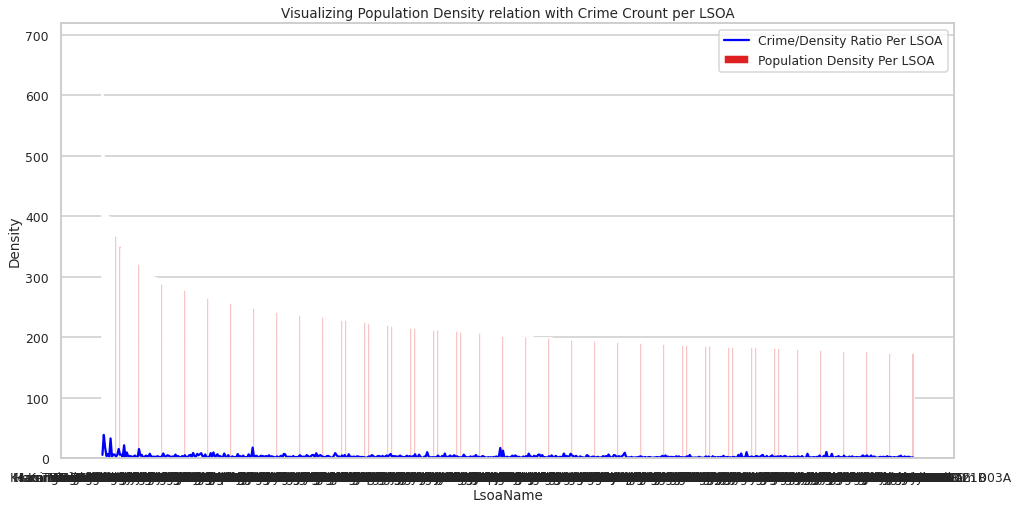

In [139]:
fig, ax1 = plt.subplots(figsize=(16,8))
# color = 'tab:green'
ax1.set_title('Visualizing Population Density relation with Crime Crount per LSOA')
ax1.set_xlabel('LSOA Name')
ax1 = sns.barplot(x=df_densityLsaoMerge['LsoaName'][0:600], y=df_densityLsaoMerge['Density'][0:600], color='r', label = 'Population Density Per LSOA')
ax1 = sns.lineplot(x=df_densityLsaoMerge['LsoaName'][0:600], y=df_densityLsaoMerge['Density/Crime'][0:600], color='b', label = 'Crime/Density Ratio Per LSOA')
ax1.legend()
plt.show()

This graph emplains that decreasing population density per LSOA has prominent impact or relation with the crime to density ratio. However, trend shows that with high density, LSOA is slightly more likely to experience a higher crime rate. This can be observed by the number of blue bumps (showing Density/Crime ratio) and height of bumps is decreasing as density decreases. 




##Exporting final DataFrame to CSV

In [141]:
df_crime.sample(10)

,Month,FallsWithin,Longitude,Latitude,Location,LsoaCode,LsoaName,Crime,District,Population
2030309,2016-07,Cheshire Constabulary,-2.362185,53.306870,Lowe Drive,E01018610,Cheshire East 009C,Anti-social behaviour,Cheshire East,1910
1308120,2017-04,Gloucestershire Constabulary,-2.101738,51.882739,Salisbury Avenue,E01022174,Cheltenham 011E,Anti-social behaviour,Cheltenham,1347
556491,2018-01,Metropolitan Police Service,-0.163961,51.425024,Mitcham Road,E01004528,Wandsworth 035D,Robbery,Wandsworth,1520
300587,2018-04,Humberside Police,-0.950129,53.684065,Stocks Drive,E01013072,East Riding of Yorkshire 042A,Anti-social behaviour,East Riding of Yorkshire,1698
1993118,2016-08,Northamptonshire Police,-0.674510,52.475462,Clarendon Close,E01026977,Corby 003C,Violence and sexual offences,Corby,1909
3422906,2015-02,Northumbria Police,-1.454217,54.945663,Boldon Drive,E01008610,South Tyneside 021A,Anti-social behaviour,South Tyneside,1407
440109,2018-02,Avon and Somerset Constabulary,-2.592566,51.405620,The Groves,E01032514,Bristol 053E,Violence and sexual offences,"Bristol, City of",1970
3348187,2015-03,North Wales Police,-2.931776,53.171172,Aled Way,W01000331,Flintshire 015F,Anti-social behaviour,Flintshire,1609
2976215,2015-07,Bedfordshire Police,-0.335859,52.035538,Midland Close,E01017440,Central Bedfordshire 011D,Anti-social behaviour,Central Bedfordshire,1374
2842382,2015-09,Lancashire Constabulary,-2.761620,53.550273,Eversley,E01025529,West Lancashire 013D,Violence and sexual offences,West Lancashire,1823


In [140]:
df_crime.to_csv(r'/content/Data/final_crime_dataframe.csv', index = False, header=True)